# **4.10 Credit Card Fraud Detection**

### **Feature Engineering + ML algo**
- 중요 Feature의 데이터 분포도 변경 (정규, log)
- 이상치 제거 (성능이 좋아진다)
- SMOTE 오버 샘플링 (정상 데이터 증식)

-----
- Logistic Regression
- LightGBM


### **Log transformation**

왜곡된 분포를 가진 데이터셋을 정규분포에 가까운 모양으로 변화시킨다.

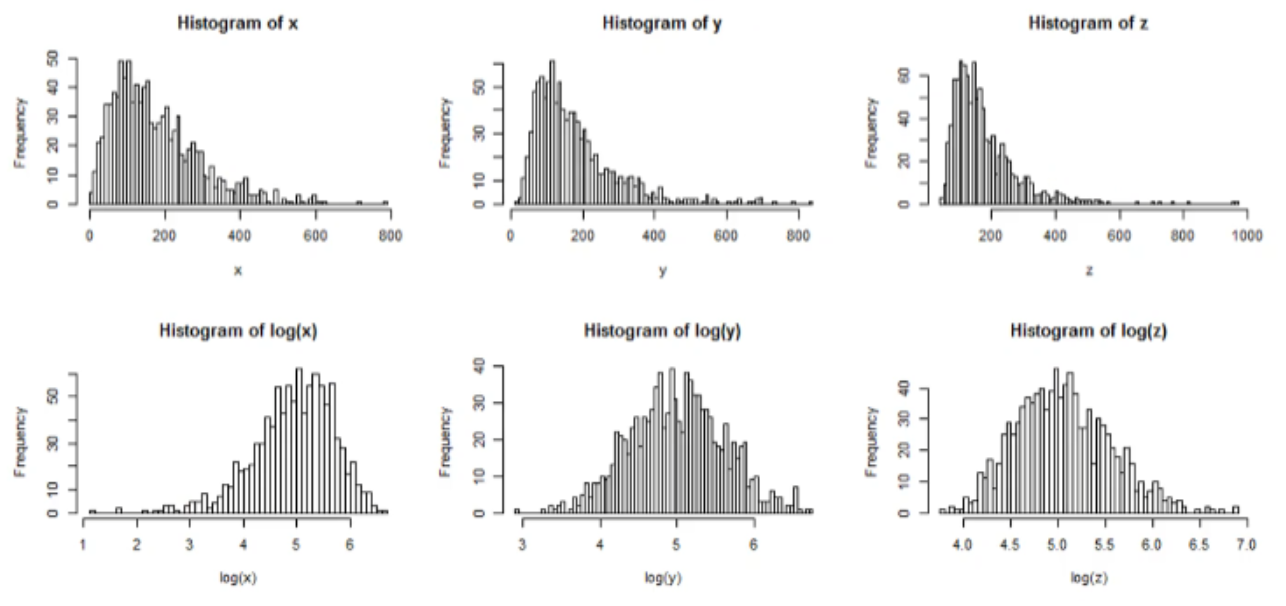

### **Outlier Removal with Inter Quantile Range**

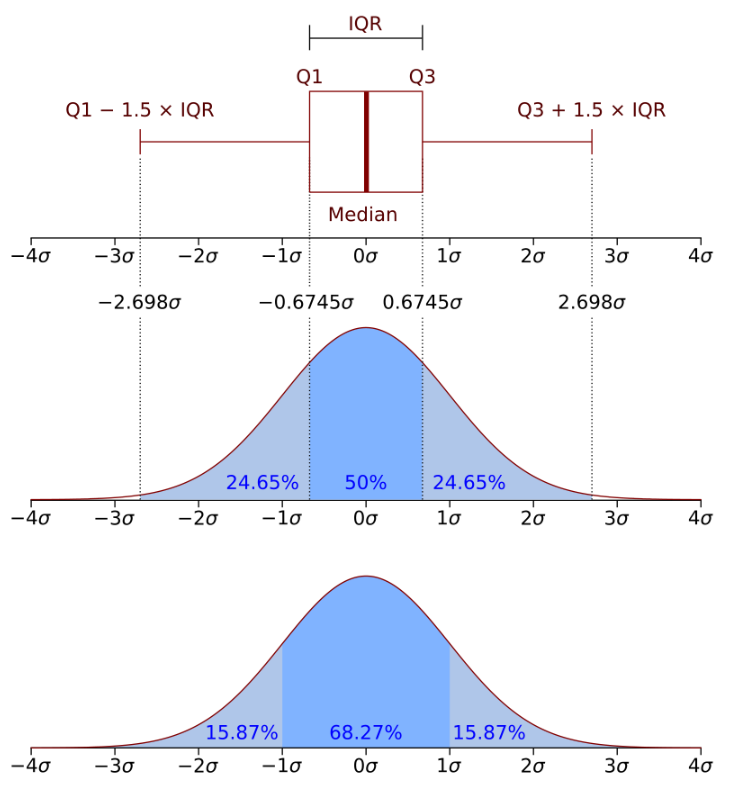

최솟값은 1/4분위수에서 1.5 * IQR값을 뺀 지점  
최댓값은 3/4분위수에서 1.5 * IQR값을 더한 지점  

그 이상의 데이터는 모두 이상치로 추정한다.

### **Undersampling Oversampling**

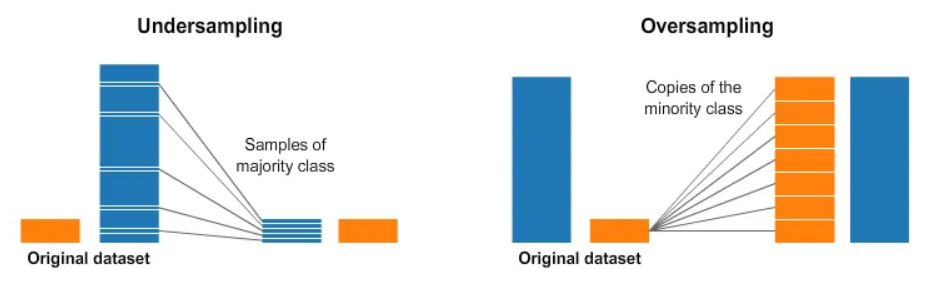

보통 정상데이터가 많고 이상데이터는 적다. 많은 데이터는 감소시키거나 적은데이터는 증가시킨다

이는 데이터의 클래스 불균형을 해소한다 보통 다운샘플링은 데이터가 넘쳐날때나 쓴다

### **SMOTE (Systhenic Minority Over-Sampling Technique)**

오버샘플링의 한 기법, KMEANS를 이용해 새로운 데이터를 만들어낸다

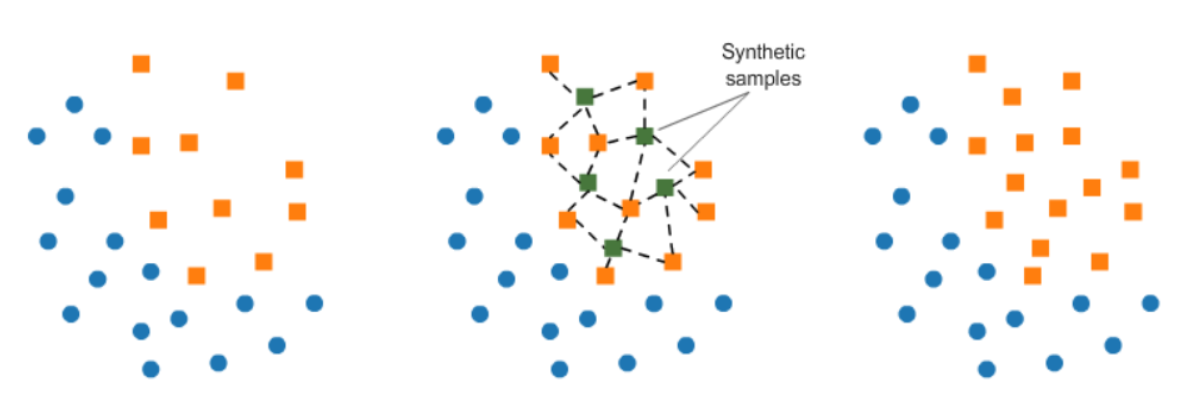

284,807건 중에 492건은 사기이다 개인정보를 보호하기 위해 피쳐들은 암호화되어있다. (Amount 제외)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')
# colab에서 돌리는 코드
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [ ]:
card_df.shape

(284807, 31)

**데이터 가공을 위한 df를 복사해서 반환**

이제 앞으로는 주요 feature에 대해서 손을 볼 것이다

In [ ]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True) # 타임 삭제
    return df_copy

In [ ]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1] # Class가 Target임
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 워낙에 데이터가 작아서 stratify를 적어주어야한다
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [ ]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행.
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85283    12]
 [   60    88]]
정확도: 0.9992, 정밀도: 0.8800, 재현율: 0.5946,    F1: 0.7097, AUC:0.9593


정확도가 좋을 수밖에 없는게 0으로만 예측해도 99퍼 정확도가 나온다.  
재현율이 1을 얼마나 잘 예측했는지 이므로 신경써야한다 (사기를 잘 찾아야)

#### **앞으로 피쳐 엔지니어링을 계속 수행할 때마다 모델을 학습, 예측, 평가해야하므로 함수 필요**

In [ ]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

**LightGBM 학습/예측/평가**  
2.1.0이상 버전에서 boost_from_average가 True가 Default임. True이면 레이블 값이 극도로 불균형 분포를 이루는 경우 재현율 및 ROC-AUC 성능이 매우 저하됨. 불균형할때는 False로 두자

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


## **데이터 분포도 변환 후 모델 학습/예측/평가**

**중요 feature의 분포도 확인**

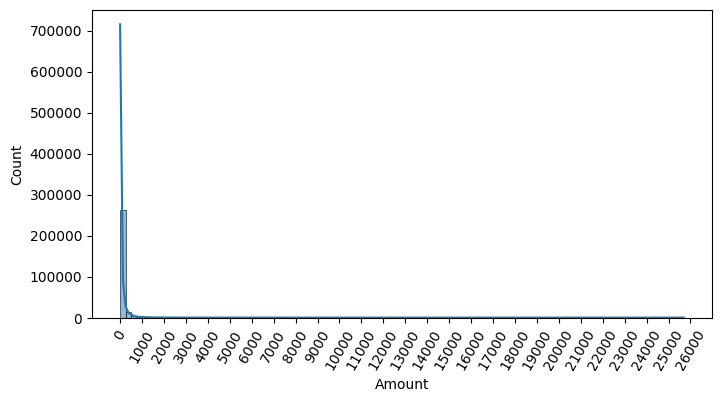

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
# 금액과 같은 요소는 어딘가에 몰려있기 쉽다 >> 정규분포꼴로 바꾸자
plt.show()

**데이터 사전 가공을 위한 별도의 함수에 StandardScaler를 이용하여 Amount 피쳐 변환**

In [ ]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [ ]:
card_df_test = get_preprocessed_df(card_df)
card_df_test.head(10)

,Amount_Scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
5,-0.338556,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0
6,-0.333279,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,0
7,-0.190107,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0
8,0.019392,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0
9,-0.338516,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,0


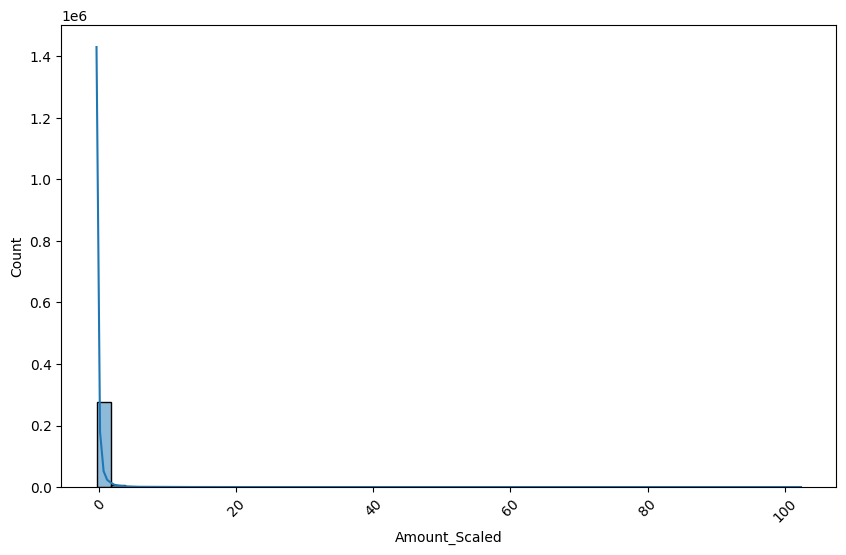

In [ ]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
sns.histplot(card_df_test['Amount_Scaled'], bins=50, kde=True)
plt.show()

In [ ]:
card_df_test['Amount_Scaled'].describe()

,Amount_Scaled
count,2.848070e+05
mean,2.913952e-17
std,1.000002e+00
min,-3.532294e-01
25%,-3.308401e-01
50%,-2.652715e-01
75%,-4.471707e-02
max,1.023622e+02


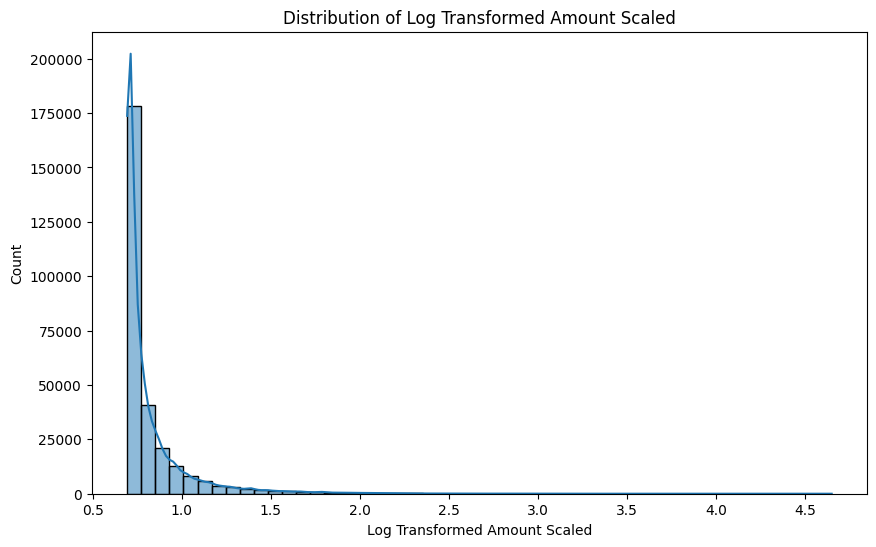

In [ ]:
# 로그 변환 적용 (음수 처리를 위해 np.log1p 사용)
card_df_test['Amount_Scaled_Log'] = np.log1p(card_df_test['Amount_Scaled'] - card_df_test['Amount_Scaled'].min() + 1)

# 시각화
plt.figure(figsize=(10, 6))
sns.histplot(card_df_test['Amount_Scaled_Log'], bins=50, kde=True)

# 축 레이블과 타이틀 설정
plt.xlabel('Log Transformed Amount Scaled')
plt.ylabel('Count')
plt.title('Distribution of Log Transformed Amount Scaled')

plt.show()
# 정규분포로 변환한다고 했는데 로그까지 씌워야 좀 보인다

**StandardScaler 변환 후 로지스틱 회귀 및 LightGBM 학습/예측/평가**

In [ ]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


오히려 성능이 감소했다.

> 이론적으로는 좋아져야하나 실제로 안그럴수도 있다.

### **Amount를 로그 변환**

In [ ]:
# 참고

import numpy as np

print(1e-1000 == 0.0)
print(np.log(1e-1000))
print(np.log(1e-1000 + 1))
print(np.log1p(1e-1000))

True
-inf
0.0
0.0


In [ ]:
var_1 = np.log1p(100)
var_2 = np.expm1(var_1)
print(var_1, var_2)

4.61512051684126 100.00000000000003


In [ ]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


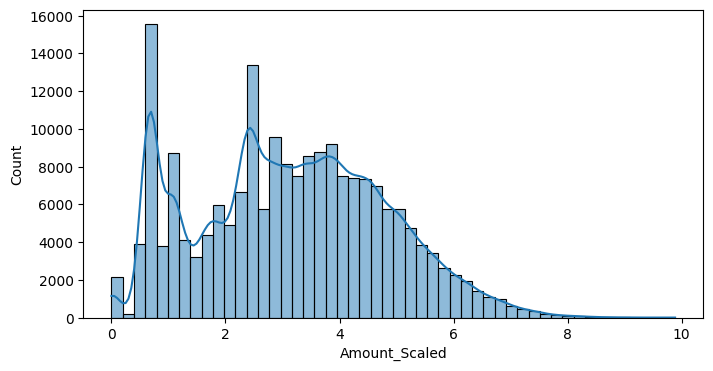

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(X_train['Amount_Scaled'], bins=50, kde=True)
plt.show()

### **Delete Outlier data, Model Train/Predict/Eval**

<Axes: >

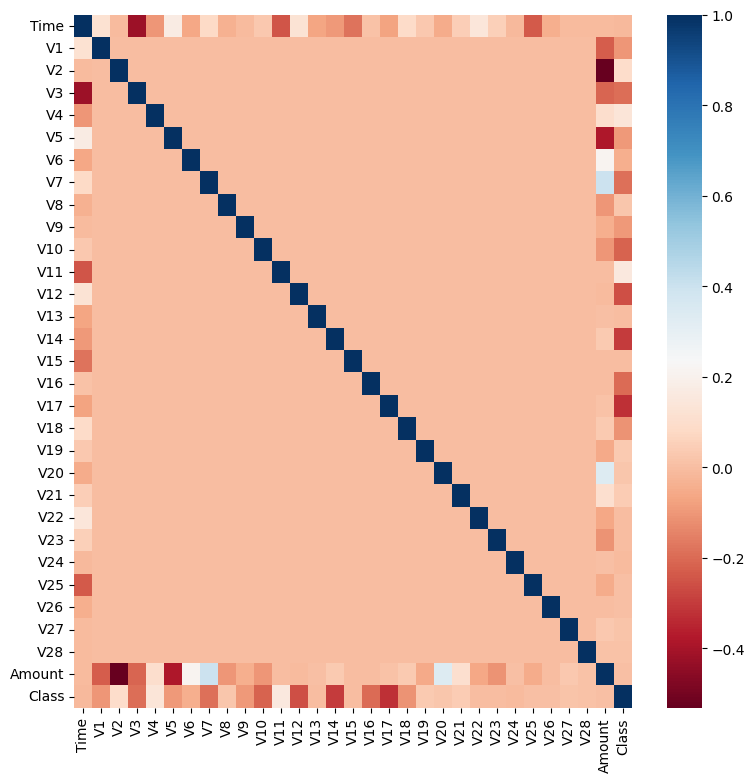

In [ ]:
plt.figure(figsize=(9, 9))
corr = card_df.corr() # 결정 레이블인 class값과 가장 상관도가 높은 피쳐를 추출
sns.heatmap(corr, cmap='RdBu')

In [ ]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
    fraud = df[df['Class']==1][column] # fraud일때의 V14
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함.
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환.
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index # 아웃라이어에 해당하는 데이터프레임의 인덱스를 반환


In [ ]:
np.percentile(card_df['V14'].values, 25)

-0.4255740124549935

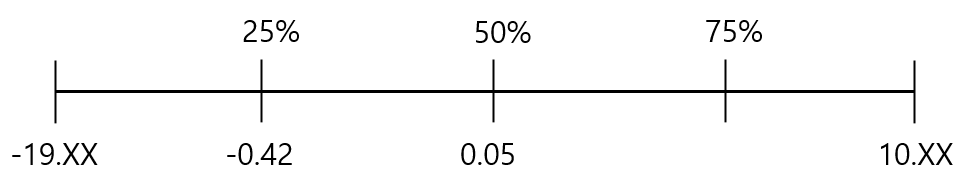

In [ ]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


###**로그변환, V14피처의 이상치 데이터를 삭제하고 모델들을 재학습/예측/평가**

In [ ]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True) # 이건 row를 제거
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


Outlier는 가능하면 적게 지우자. 기준을 엄격하게해서..

###**SMOTE oversampling 적용 후 모델 학습/예측/평가**

In [ ]:
import imblearn

print(imblearn.__version__)

0.12.3


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0    199020
1    199020
Name: count, dtype: int64


In [ ]:
print(y_train.value_counts())
print(y_train_over.value_counts())

Class
0    199020
1       342
Name: count, dtype: int64
Class
0    199020
1    199020
Name: count, dtype: int64


당연한 이야기지만  오버샘플링한 데이터는 학습에만 사용해야한다. test에는 사용하면 안된다

In [ ]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


정밀도가 너무 낮아져서 실전에 사용하기에는 무리가 있다

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

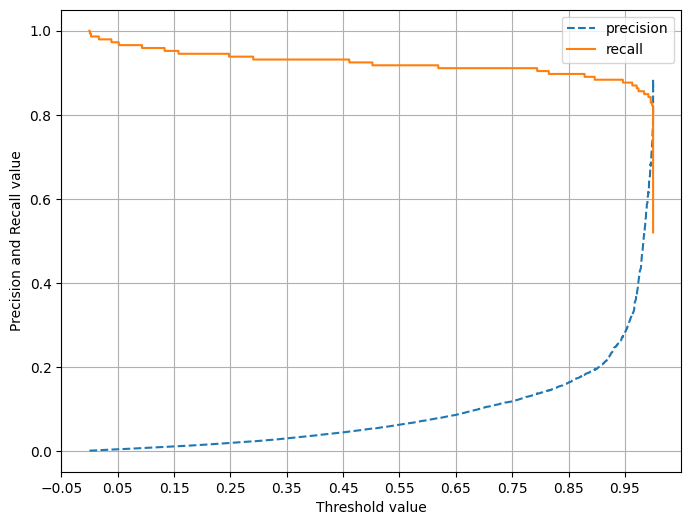

In [ ]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814


기존 0.9996 0.9603, 0.8288에 비해 정밀도는 떨어졌으나 중요하게 생각하는 재현율은 증가하였다.  

나중에 로지스틱회귀의 특징을 한번 살펴보자 정밀도가 저렇게 나오는 이유가 무엇인지..?